In [139]:
from numpy import mean
from numpy import std
import seaborn as sns
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from sklearn.metrics import classification_report
from keras.layers import Permute, Reshape
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [140]:
features=list()
with open('features.txt') as feat:
    features=[l.split()[1] for l in feat.readlines()]
print("Number of features = {}".format(len(features)))

Number of features = 561


In [141]:
train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None, encoding='latin-1')
train.columns = features
train['subject'] = pd.read_csv('subject_train.txt', header=None)
train['Activity'] = pd.read_csv('y_train.txt', names=['Activity'])
train['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
4258,0.4675,-0.010156,-0.130696,-0.851548,-0.716999,-0.66939,-0.875979,-0.741534,-0.705379,-0.698487,...,-0.068532,0.568737,0.126402,0.567203,0.38766,-0.386832,-0.59521,21,6,LAYING


In [142]:
train['ActivityName'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [143]:
train.shape

(7352, 564)

In [144]:
test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None, encoding='latin-1')
test.columns = features
test['subject'] = pd.read_csv('subject_test.txt', header=None)
test['Activity'] = pd.read_csv('y_test.txt', names=['Activity'])
test['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})
test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
891,0.41153,-0.000037,-0.119374,-0.205466,-0.385864,-0.025581,-0.248214,-0.366483,-0.032404,0.013598,...,-0.767094,-0.119705,0.976913,0.536782,-0.575903,0.044908,0.318982,9,2,SITTING


In [145]:
test.shape

(2947, 564)

In [146]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


In [151]:
def file_load(filepath):
    df = read_csv(filepath, header=None, delim_whitespace=True)
    return df.values 

In [152]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = dstack(datalist)
    return datalist

In [153]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [154]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + 'UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + 'UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 400, 150
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
n_steps = 4
n_length = 32


(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense


In [71]:
def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_metrices(model_):
    # Predicting the test data
    pred = model_.predict(testX, batch_size=128)
    pred = np.argmax(pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(testy.argmax(axis=1), pred)
    
    # Define classes for plotting
    classes = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
    
    # Plot the confusion matrix
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Reds')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    print(classification_report(testy.argmax(axis=1), pred))

    # Calculate accuracy, sensitivity, and specificity
    total = sum(sum(cm))
    accuracy = np.trace(cm) / total  # np.trace(cm) gives the sum of diagonal elements
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True positive rate for class 0
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])  # True negative rate for class 1

    # Print metrics
    print("Accuracy: {:.4f}".format(accuracy))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))


In [29]:

import pandas as pd
import numpy as np # linear algebra
from numpy import mean
from numpy import std
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,GRU,SimpleRNN
from keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [57]:
trainX.shape

(7352, 4, 32, 9)

# PROPOSED

In [188]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Multiply, Add, Input, Reshape, GlobalAveragePooling2D, Conv2D, GlobalMaxPooling1D


# Convolved Normalized Pooled (CNPM) Block
def cnpm_block(inputs, filters, kernel_size=5, pool_size=2):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # x = MaxPooling1D(pool_size)(x)
    return x

# Identity Block
def identity_block(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Basic Block
def basic_block(inputs, filters, kernel_size):
    x = Conv1D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    # x = ReLU()(x)
    return x

# Identity and Basic (IDBN) Block
def identity_basic_block(inputs, filters, kernel_sizes=[3, 5, 7]):
    idb_outputs = []

    for kernel_size in kernel_sizes:
        id_output = identity_block(inputs, filters, kernel_size)
        id_output = identity_block(id_output, filters, kernel_size)
        basic_output = basic_block(id_output, filters, kernel_size)
        combined_output = Add()([inputs, basic_output])
        combined_output = ReLU()(combined_output)
        idb_outputs.append(combined_output)

    if len(idb_outputs) > 1:
        idb_combined = Add()(idb_outputs)
    else:
        idb_combined = idb_outputs[0]
    
    return idb_combined

# Channel Attention Block
def channel_attention(inputs, reduction_ratio=16):
    channel = inputs.shape[-1]
    
    # Global Average Pooling
    channel_avg_pool = GlobalAveragePooling1D()(inputs)
    channel_max_pool = GlobalMaxPooling1D()(inputs)

    shared_dense_1 = Dense(channel // reduction_ratio, activation='relu')
    shared_dense_2 = Dense(channel, activation='sigmoid')

    avg_out = shared_dense_2(shared_dense_1(channel_avg_pool))
    max_out = shared_dense_2(shared_dense_1(channel_max_pool))

    # Combine the outputs of average and max pooling
    combined_out = Add()([avg_out, max_out])
    combined_out = tf.expand_dims(combined_out, axis=1)

    # Apply the attention weights to the input features
    channel_attention_output = Multiply()([inputs, combined_out])
    return channel_attention_output

# Spatial Attention Block
def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

    concat = tf.concat([avg_pool, max_pool], axis=-1)
    spatial_attention = Conv1D(1, 7, padding='same', activation='sigmoid')(concat)

    # Apply the attention weights to the input features
    spatial_attention_output = Multiply()([inputs, spatial_attention])
    return spatial_attention_output

# Channel and Spatial Attention (CASb) Block
def channel_spatial_attention_block(inputs, reduction_ratio=16):
    x = channel_attention(inputs, reduction_ratio)
    x = spatial_attention(x)
    return x

# WISNet Block
def wisnet_block(inputs, filters, kernel_sizes=[3, 5, 7], reduction_ratio=16):
    x = identity_basic_block(inputs, filters, kernel_sizes)
    x = channel_spatial_attention_block(x, reduction_ratio)
    return x

# Building the WISNet Model
def build_wisnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNPM Block
    y = cnpm_block(inputs, 64, kernel_size=5)

    # IDBN1 Block
    x = identity_basic_block(y, 64, kernel_sizes=[3, 5, 7])

    # CASb Block
    x = channel_spatial_attention_block(x, reduction_ratio=16)
    x = Add()([x, y])

    # IDBN2 Block
    x = identity_basic_block(x, 64, kernel_sizes=[3, 5, 7])

    # CASb Block
#     x = channel_spatial_attention_block(x, reduction_ratio=16)

    # Global Pooling and Output Layer
    x = GlobalAveragePooling1D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, x)
    return model

# Define model parameters
input_shape = ( 128, 9)  # Shape after reshaping
num_classes = 6            # Number of output classes

# Build and summarize the model
model = build_wisnet(input_shape, num_classes)
# model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Early stopping for quicker training
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr *= 0.8  # Decrease learning rate by 20% every 5 epochs
    return lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=30,
                    batch_size=batch_size, verbose=1, callbacks=[early_stopping, lr_callback])


Epoch 1/30
58/58 [==============================] - 6s 24ms/step - loss: 0.2712 - accuracy: 0.8962 - val_loss: 2.3096 - val_accuracy: 0.1666 - lr: 5.0000e-04
Epoch 2/30
58/58 [==============================] - 1s 18ms/step - loss: 0.1310 - accuracy: 0.9476 - val_loss: 3.0821 - val_accuracy: 0.1988 - lr: 5.0000e-04
Epoch 3/30
58/58 [==============================] - 1s 18ms/step - loss: 0.1144 - accuracy: 0.9531 - val_loss: 3.2560 - val_accuracy: 0.4099 - lr: 5.0000e-04
Epoch 4/30
58/58 [==============================] - 1s 18ms/step - loss: 0.1071 - accuracy: 0.9524 - val_loss: 2.8405 - val_accuracy: 0.4092 - lr: 5.0000e-04
Epoch 5/30
58/58 [==============================] - 1s 18ms/step - loss: 0.0979 - accuracy: 0.9574 - val_loss: 2.3675 - val_accuracy: 0.4605 - lr: 5.0000e-04
Epoch 6/30
58/58 [==============================] - 1s 18ms/step - loss: 0.0933 - accuracy: 0.9573 - val_loss: 1.7390 - val_accuracy: 0.5304 - lr: 4.0000e-04
Epoch 7/30
58/58 [==============================] - 

93/93 [==============================] - 0s 2ms/step
17682


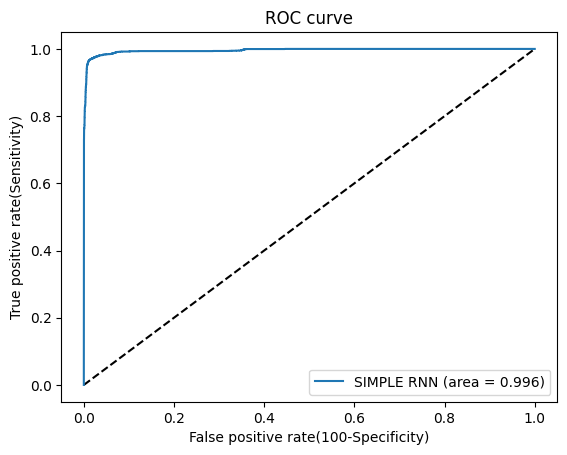

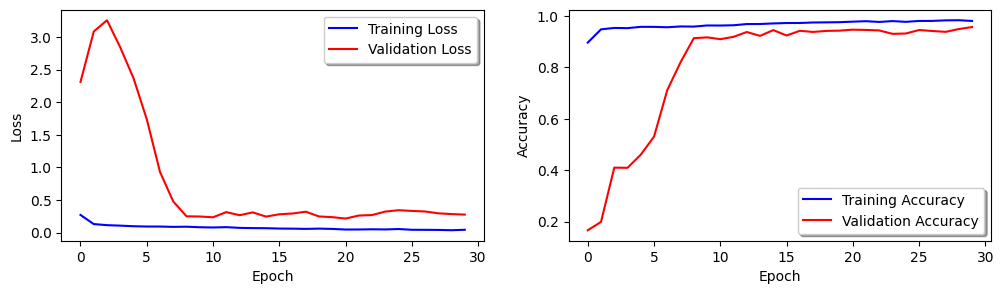

24/24 [==============================] - 0s 4ms/step


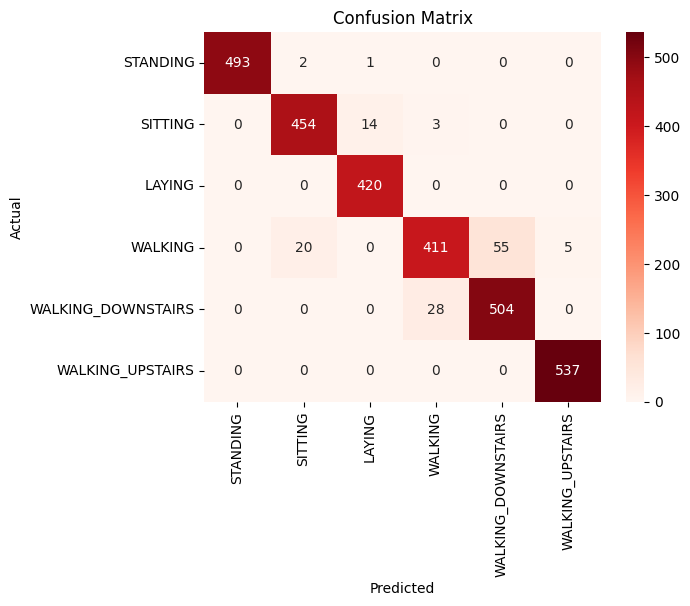

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       496
           1       0.95      0.96      0.96       471
           2       0.97      1.00      0.98       420
           3       0.93      0.84      0.88       491
           4       0.90      0.95      0.92       532
           5       0.99      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

Accuracy: 0.9566
Sensitivity: 0.9960
Specificity: 1.0000


In [189]:

import sklearn.metrics
def plot_roc(model_, name):
    plt.figure()
    ax = plt.subplot()
    ax.set_title('ROC Curve')
    pred = model_.predict(testX).ravel()
    print(pred.size)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(testy.ravel(), pred)
    ac = sklearn.metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(name, ac))
    plt.xlabel('False positive rate(100-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show
plot_roc(model,"SIMPLE RNN")



display_history(history)
plot_metrices(model)